Project chapters:

1. Data Engineering  <br />
    a) data discovery  <br />
    b) data cleanup
    
2. Data Analysis <br />
    a) business relevant summary <br />
    b) data correlations <br />
3. Data Science <br />
    a) Bike usage predictive model <br />
    b) feature engineering <br />
  

IDEAS
* build a LR model (or other model) to predict the Rented Bike Count
* predict visibility based on other weather features
* check rent bike distribution per day (histogram)
* Hypothesis testing: Spring time has higher mean bike rent count
* analyze rented bike count fluctuations across the year

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Rogo\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Engineering

## Data discovery

In [25]:
bikes_df = pd.read_csv('SeoulBikeData.csv')
print(bikes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

Data types to correct:
0 Date -> Datetime
12 Holiday -> Boolean
13 Functioning Day -> Boolean / remove

In [26]:
bikes_df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [30]:
bikes_df['Date'] = pd.to_datetime(bikes_df['Date'], format="%d/%m/%Y")
print(bikes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      8760 non-null   datetime64[ns]
 1   Rented Bike Count         8760 non-null   int64         
 2   Hour                      8760 non-null   int64         
 3   Temperature(C)            8760 non-null   float64       
 4   Humidity(%)               8760 non-null   int64         
 5   Wind speed (m/s)          8760 non-null   float64       
 6   Visibility (10m)          8760 non-null   int64         
 7   Dew point temperature(C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)   8760 non-null   float64       
 9   Rainfall(mm)              8760 non-null   float64       
 10  Snowfall (cm)             8760 non-null   float64       
 11  Seasons                   8760 non-null   object        
 12  Holiday             

In [4]:
bikes_df['Seasons'].unique()

array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

In [5]:
bikes_df['Holiday'].unique()

array(['No Holiday', 'Holiday'], dtype=object)

In [6]:
bikes_df['Functioning Day'].unique()

array(['Yes', 'No'], dtype=object)

In [7]:
bikes_df.head(20)
# len(bikes_df.Hour.unique())

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8735,29/11/2018,559,23,2.6,56,1.9,1394,-5.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8736,30/11/2018,474,0,1.8,62,1.6,1411,-4.7,0.0,0.0,0.0,Autumn,No Holiday,Yes
8737,30/11/2018,456,1,1.3,63,2.0,1379,-4.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8738,30/11/2018,300,2,0.6,66,0.5,1368,-5.0,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [8]:
grouping = bikes_df.groupby('Holiday').size().reset_index()
grouping.columns= ['Feature', 'Count']
print(grouping)

      Feature  Count
0     Holiday    432
1  No Holiday   8328


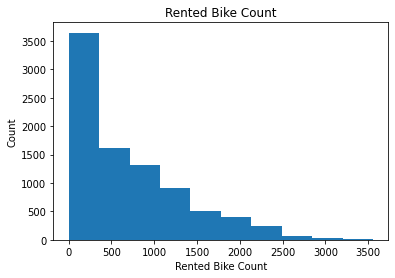

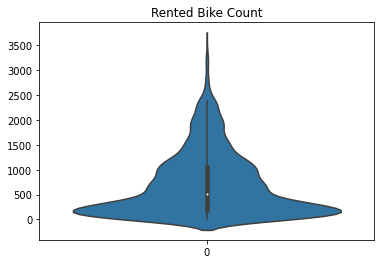

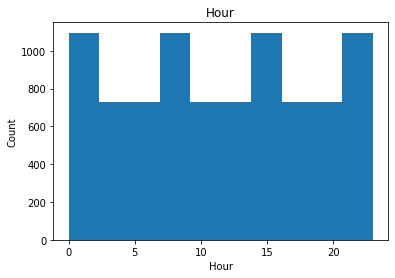

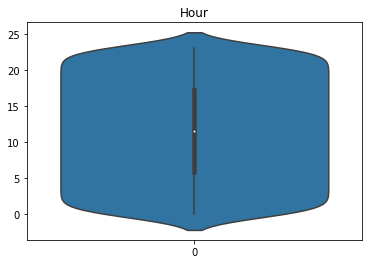

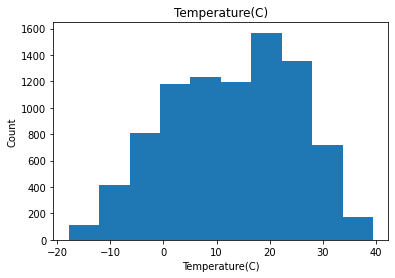

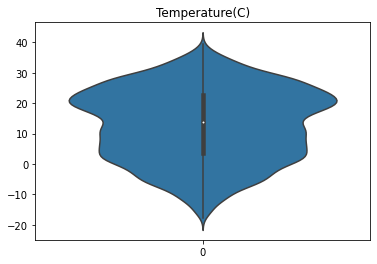

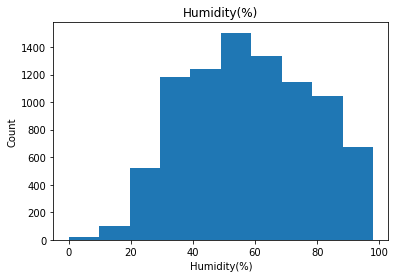

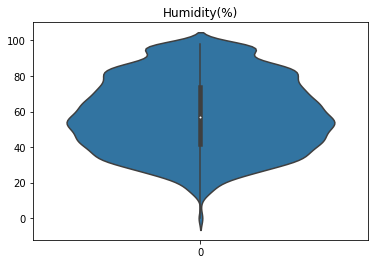

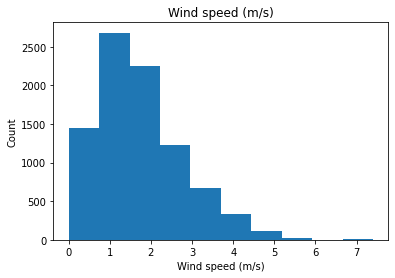

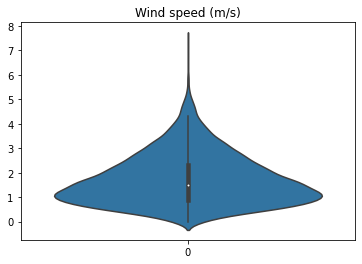

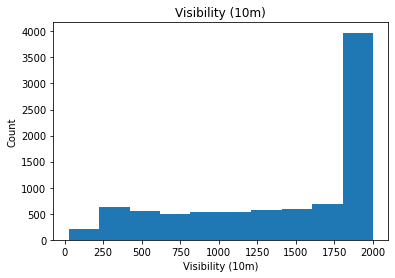

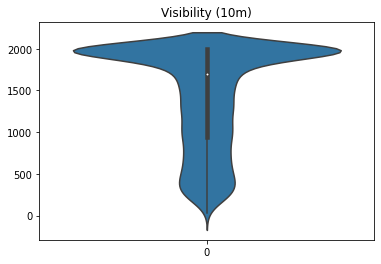

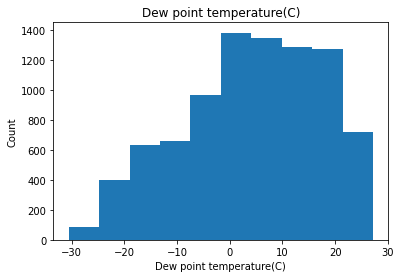

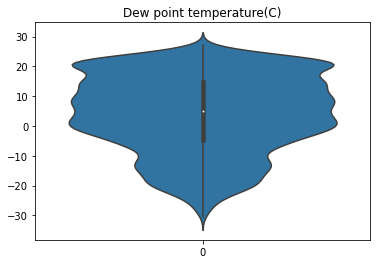

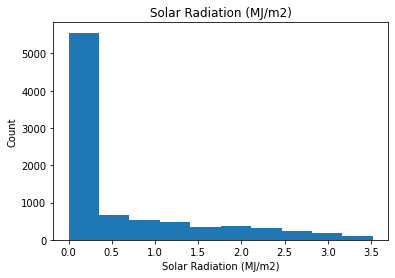

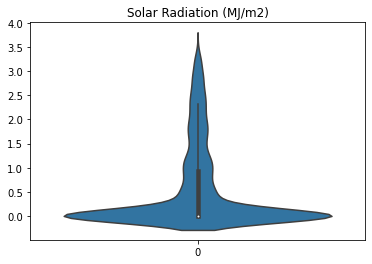

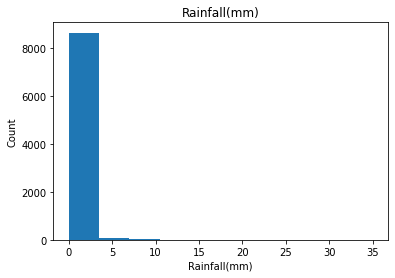

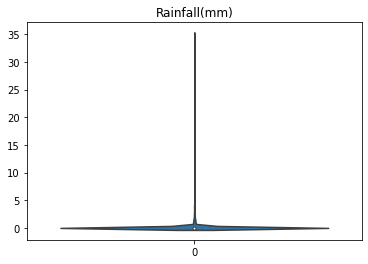

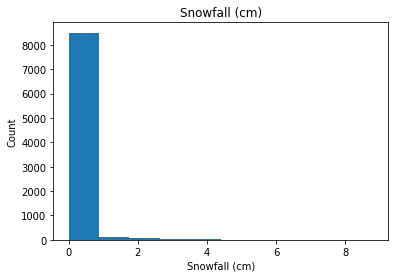

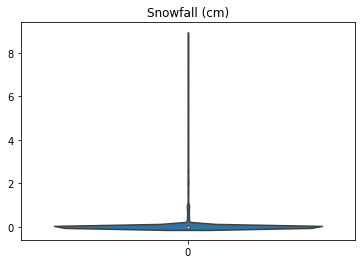

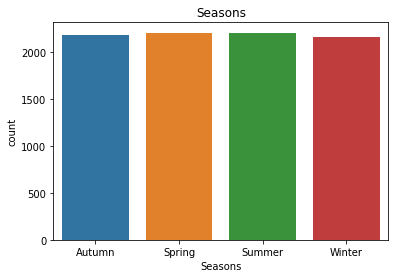

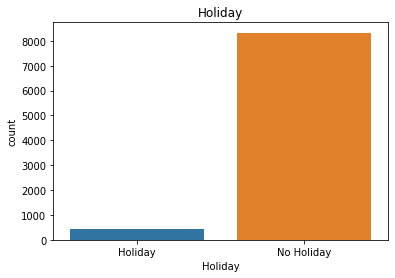

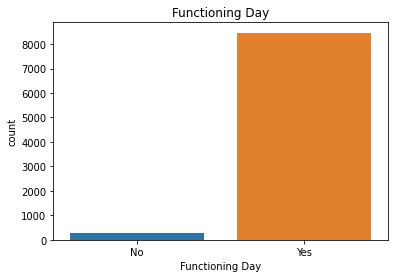

In [9]:
for i in bikes_df.columns:
    if i == 'Date':
        continue
    elif bikes_df[i].dtype == 'object':
        grouping = bikes_df.groupby(i).size().reset_index()
        grouping.columns = [i, 'count']
        sns.barplot(data = grouping,  x = i, y = 'count')
        plt.title(i)
        plt.show()
        plt.clf
    else:
        plt.hist(bikes_df[i])
        plt.title(i)
        plt.xlabel(i)
        plt.ylabel('Count')
        plt.show()
        plt.clf
        sns.violinplot(data=bikes_df[i])
        plt.title(i)
        plt.show()
        plt.clf

Visibility is heavily skewed (do the violin plot for median check)
Temp and Humidity are normally distributed
Wind speed slightly right skewed
Dew point temperature slightly left skewed
Solar radiation, small variance, do the violin plot
Rainfall and snowfall - do more bins, handle outliers
Season - will be correlated with other features

In [10]:
print(bikes_df.shape)
print(len(bikes_df[bikes_df['Functioning Day'] == 'No']))


(8760, 14)
295


In [11]:
# dropping the data when the service was not functioning at all, as it would affect the accuracy of the model
bikes_df = bikes_df[bikes_df['Functioning Day'] == 'Yes']
bikes_df = bikes_df.drop(columns=['Functioning Day'])
print(bikes_df.shape)

(8465, 13)


## DATA CORRELATIONS

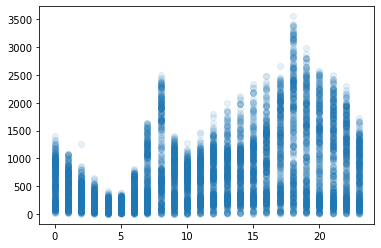

In [12]:
plt.scatter(data=bikes_df, x='Hour', y='Rented Bike Count', alpha=0.1)
plt.show()

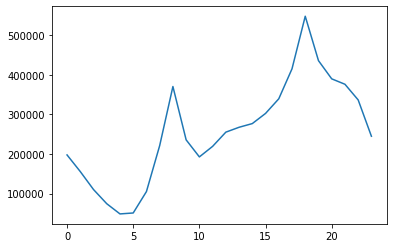

In [13]:
grouping = bikes_df[['Hour','Rented Bike Count']].groupby(['Hour']).sum().reset_index()
plt.plot(grouping['Hour'], grouping['Rented Bike Count'])
plt.show()

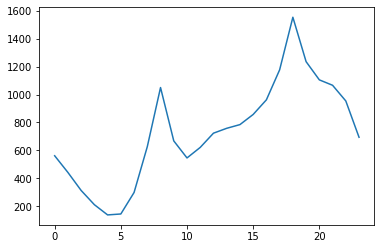

In [14]:
grouping = bikes_df[['Hour','Rented Bike Count']].groupby(['Hour']).mean().reset_index()
plt.plot(grouping['Hour'], grouping['Rented Bike Count'])
plt.show()

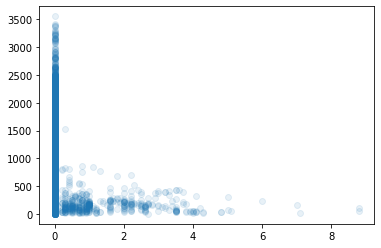

In [15]:
plt.scatter(data=bikes_df, x='Snowfall (cm)', y='Rented Bike Count', alpha = 0.1)
plt.show()

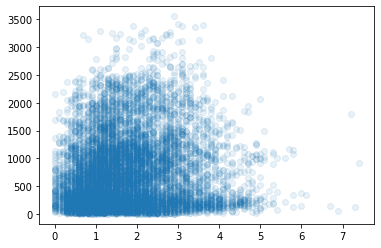

In [16]:
plt.scatter(data=bikes_df, x='Wind speed (m/s)', y='Rented Bike Count', alpha = 0.1)
plt.show()